# **My Aproach to the titanic competition** 

### *Imports*

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import string
from IPython.display import display, HTML
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler , LabelEncoder
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## *Data Analysis,Feature Enginering,Preprocessing*

In [41]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)
df_train = pd.read_csv('data_sets/train.csv')
df_test = pd.read_csv('data_sets/test.csv')
df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all = concat_df(df_train, df_test)
dfs = [df_train, df_test]
print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


### **1.1 Overview**

* `PassengerId` serves as a unique identifier for each row and doesn't influence the target variable.
* `Survived` is the target variable, indicating the survival status of passengers:
    - **1 = Survived**
    - **0 = Did not survive**
* `Pclass` (Passenger Class) represents the socio-economic status of the passengers, categorized into three ordinal levels:
    - **1 = Upper Class**
    - **2 = Middle Class**
    - **3 = Lower Class**
* `Name`, `Sex`, and `Age` are straightforward descriptors of the passengers.
* `SibSp` indicates the total count of siblings and spouses aboard with the passenger.
* `Parch` signifies the total number of parents and children traveling with the passenger.
* `Ticket` is the ticket number assigned to the passenger.
* `Fare` denotes the ticket price paid by the passenger.
* `Cabin` indicates the cabin number where the passenger was accommodated.
* `Embarked` refers to the port where the passenger boarded the ship, classified into three categories:
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

In this context, our goal is to predict the `Survived` variable, leveraging the features.


In [42]:
def display_missing(df):    
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [43]:
df_all_corr = df_all.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
0,Age,Age,1.000000
9,Age,Pclass,0.408106
18,Age,SibSp,0.243699
21,Age,Fare,0.178740
26,Age,Parch,0.150917
30,Age,Survived,0.077221
41,Age,PassengerId,0.028814


### **1.2 Age**
* `Age` is filled using the median age of Pclass groups is the most suitable choice due to its strong correlation with Age (0.408106). Additionally, it makes more sense to categorize ages by passenger classes rather than other features.

In [44]:
grouped = df_train.groupby(['Sex', 'Pclass'])['Age'].transform('median')
df_train['Age'].fillna(grouped, inplace=True)
grouped = df_test.groupby(['Sex', 'Pclass'])['Age'].transform('median')
df_test['Age'].fillna(grouped, inplace=True)

/tmp/ipykernel_3618/922872297.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Age'].fillna(grouped, inplace=True)
/tmp/ipykernel_3618/922872297.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

 **Stone, Mrs. George Nelson (Martha Evelyn)** Boarded from S (Southampton) along with her maid **Amelie Icard**. This information is available on the Wikipedia


In [45]:
df_train['Embarked'] = df_train['Embarked'].fillna('S')

### **1.3 Fare**

There is only one passenger with a missing `Fare` value in the test set. We can infer that `Fare` is associated with family size (`Parch` and `SibSp`) and `Pclass` features. To fill the missing value, using the median `Fare` of a male passenger with a third-class ticket and no family.


In [46]:
med_fare = df_test.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

### **1.4 Deck**

A significant portion of the `Cabin` feature is missing, but we can't ignore it completely since some cabins may have higher survival rates. The first letter of the `Cabin` values indicates the deck location. These decks were generally separated by passenger class, though some served multiple classes:

* **A**, **B**, and **C** decks were exclusively for 1st class passengers.
* **D** and **E** decks accommodated all classes.
* **F** and **G** decks were shared by both 2nd and 3rd class passengers.
* Moving from **A** to **G**, the distance to the staircase increases, which might impact survival rates.



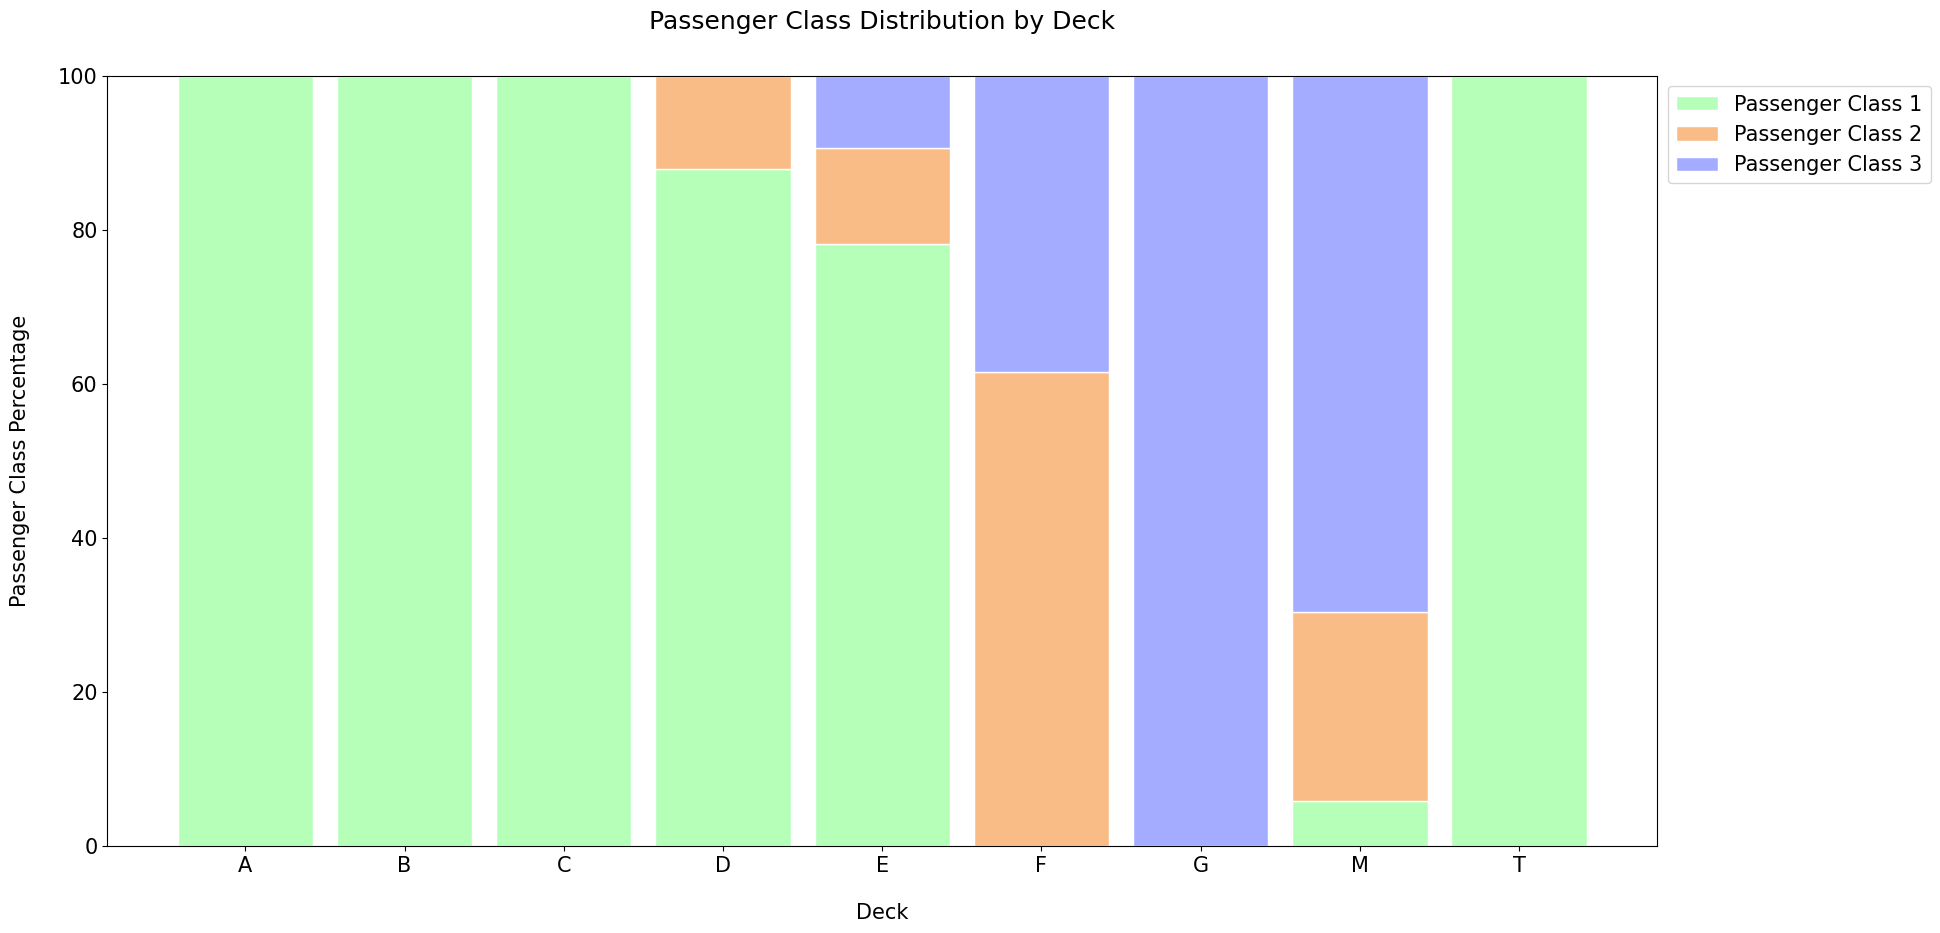

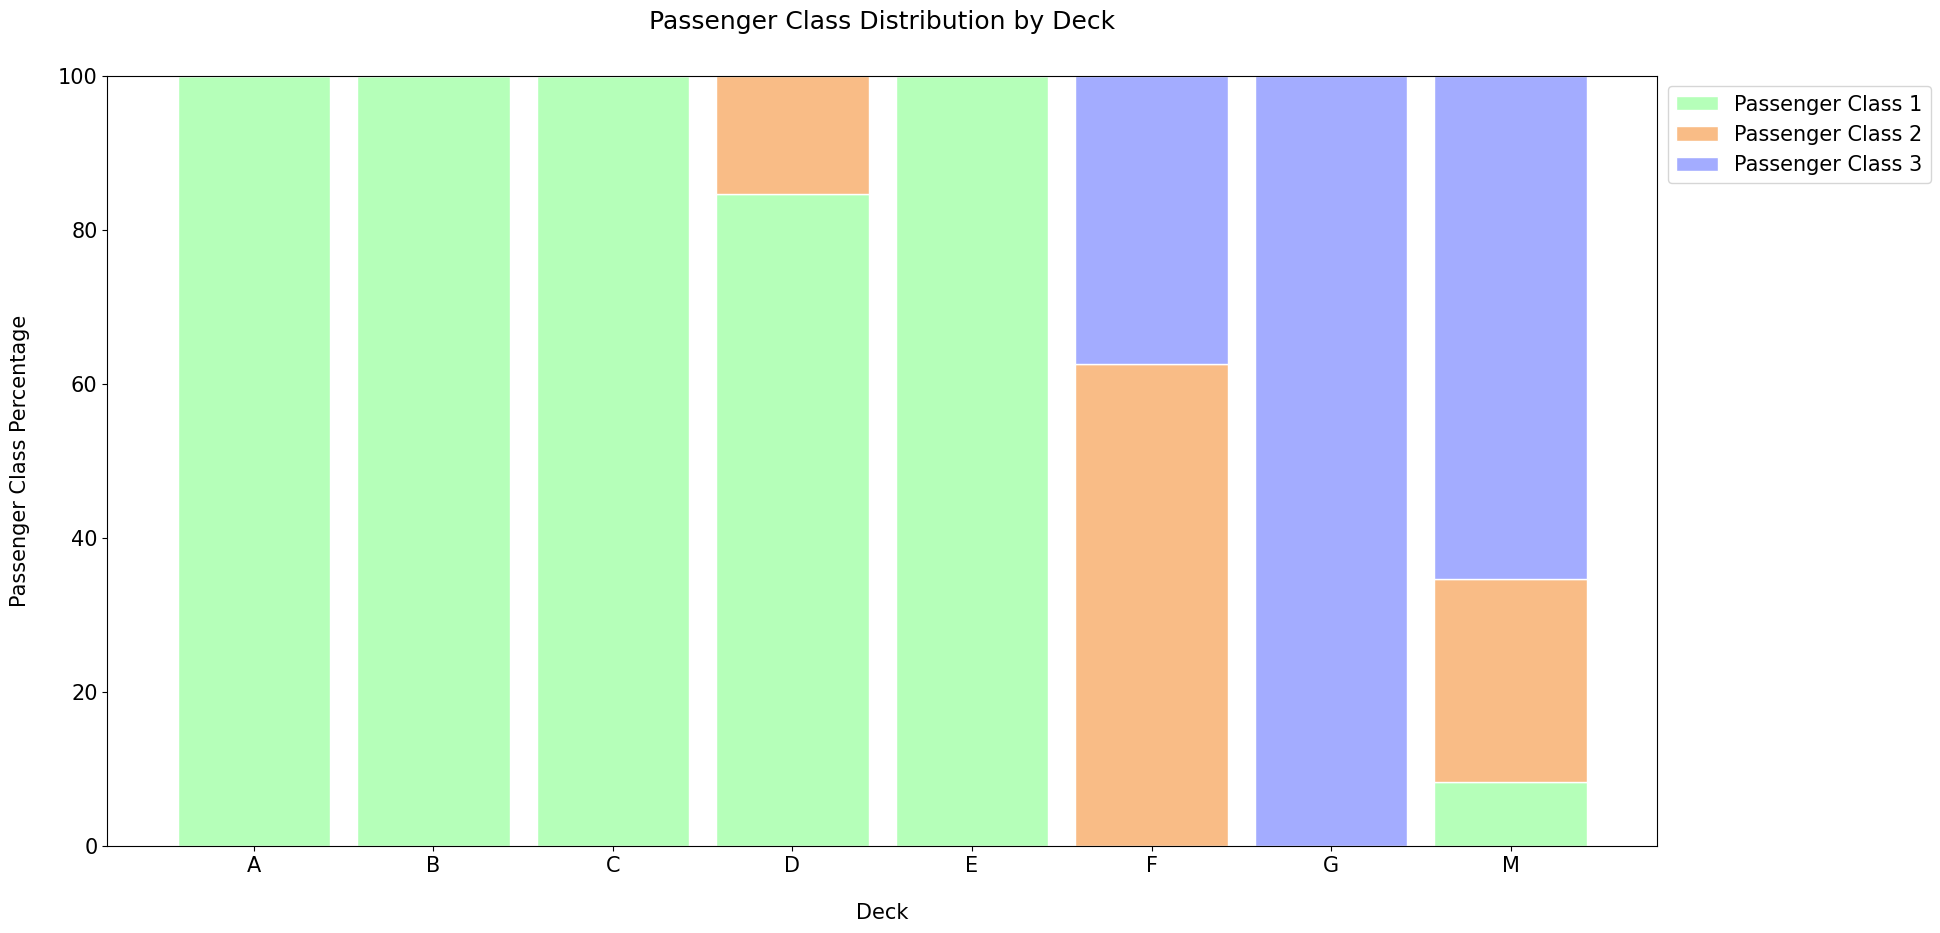

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_train['Deck'] = df_train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_test['Deck'] = df_test['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

# Grouping and counting by Deck and Pclass
df_train_decks = (df_train.groupby(['Deck', 'Pclass'])
                .size()
                .unstack(fill_value=0)
                .transpose())
df_test_decks = (df_test.groupby(['Deck', 'Pclass'])
                .size()
                .unstack(fill_value=0)
                .transpose())
def get_pclass_distribution(df):
  
    deck_counts = {deck: {pclass: 0 for pclass in range(1, 4)} for deck in df.columns}

    for deck in df.columns:
        for pclass in range(1, 4):
            count = df.get(deck, {}).get(pclass, 0)
            deck_counts[deck][pclass] = count

    df_counts = pd.DataFrame(deck_counts)

    # Calculate percentages
    deck_percentages = df_counts.apply(lambda x: (x / x.sum()) * 100, axis=0).to_dict()

    return deck_counts, deck_percentages

def plot_pclass_distribution(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = df_percentages.index
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85

    pclass1 = df_percentages[1]
    pclass2 = df_percentages[2]
    pclass3 = df_percentages[3]

    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution by Deck', size=18, y=1.05)

    plt.show()
train_deck_count, train_deck_per = get_pclass_distribution(df_train_decks)
plot_pclass_distribution(train_deck_per)
test_deck_count, test_deck_per = get_pclass_distribution(df_test_decks)
plot_pclass_distribution(test_deck_per)


*As we can see, the distribution in both sets is similar, but the test set does not have deck "T". Let's handle that.Every one in deck T is first class so its fine to assign them to either A/B/C*



In [48]:
idx = df_train[df_train['Deck'] == 'T'].index
df_train.loc[idx, 'Deck'] = 'C'

*8 decks is a bit to many let's group them*


In [49]:
def generalize_deck(df):
    df['Deck'] = df['Deck'].replace(['A', 'B', 'C'], 'ABC')
    df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
    df['Deck'] = df['Deck'].replace(['F', 'G'], 'FG')
    
    return df
generalize_deck(df_train)
generalize_deck(df_test)
df_train['Deck'].value_counts()



Deck
M      687
ABC    122
DE      65
FG      17
Name: count, dtype: int64

*Lets drop the cabin feature*

In [50]:
df_train.drop(['Cabin'], inplace=True, axis=1)
df_test.drop(['Cabin'], inplace=True, axis=1)
for df in dfs:
    display_missing(df)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Embarked column missing values: 0
Deck column missing values: 0


PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Embarked column missing values: 0
Deck column missing values: 0




*Apply quantile-based discretization to the 'Fare' column of the training and test dataframes.*

In [51]:
df_train['Fare'] = pd.qcut(df_all['Fare'], 12)
df_test['Fare'] = pd.qcut(df_all['Fare'], 12)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,"(-0.001, 7.25]",S,M
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,"(53.1, 82.267]",C,ABC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,"(7.896, 8.662]",S,M
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,"(31.275, 53.1]",S,ABC
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,"(7.896, 8.662]",S,M


*Grouping passangers by age*

In [52]:
def get_age_group(age: float):
    if np.isnan(age): return 'Unknown'
    
    if age <= 1/12: return 'Newborn'
    elif age <= 1: return 'Infant'
    elif age <= 12: return 'Child'
    elif age <= 17: return 'Adolescent'
    elif age <= 65: return 'Adult'
    else: return 'Senior'
    
df_train['AgeGrp'] = df['Age'].apply(get_age_group)
df_test['AgeGrp'] = df_test['Age'].apply(get_age_group)

df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,AgeGrp
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,"(-0.001, 7.25]",S,M,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,"(53.1, 82.267]",C,ABC,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,"(7.896, 8.662]",S,M,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,"(31.275, 53.1]",S,ABC,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,"(7.896, 8.662]",S,M,Adult


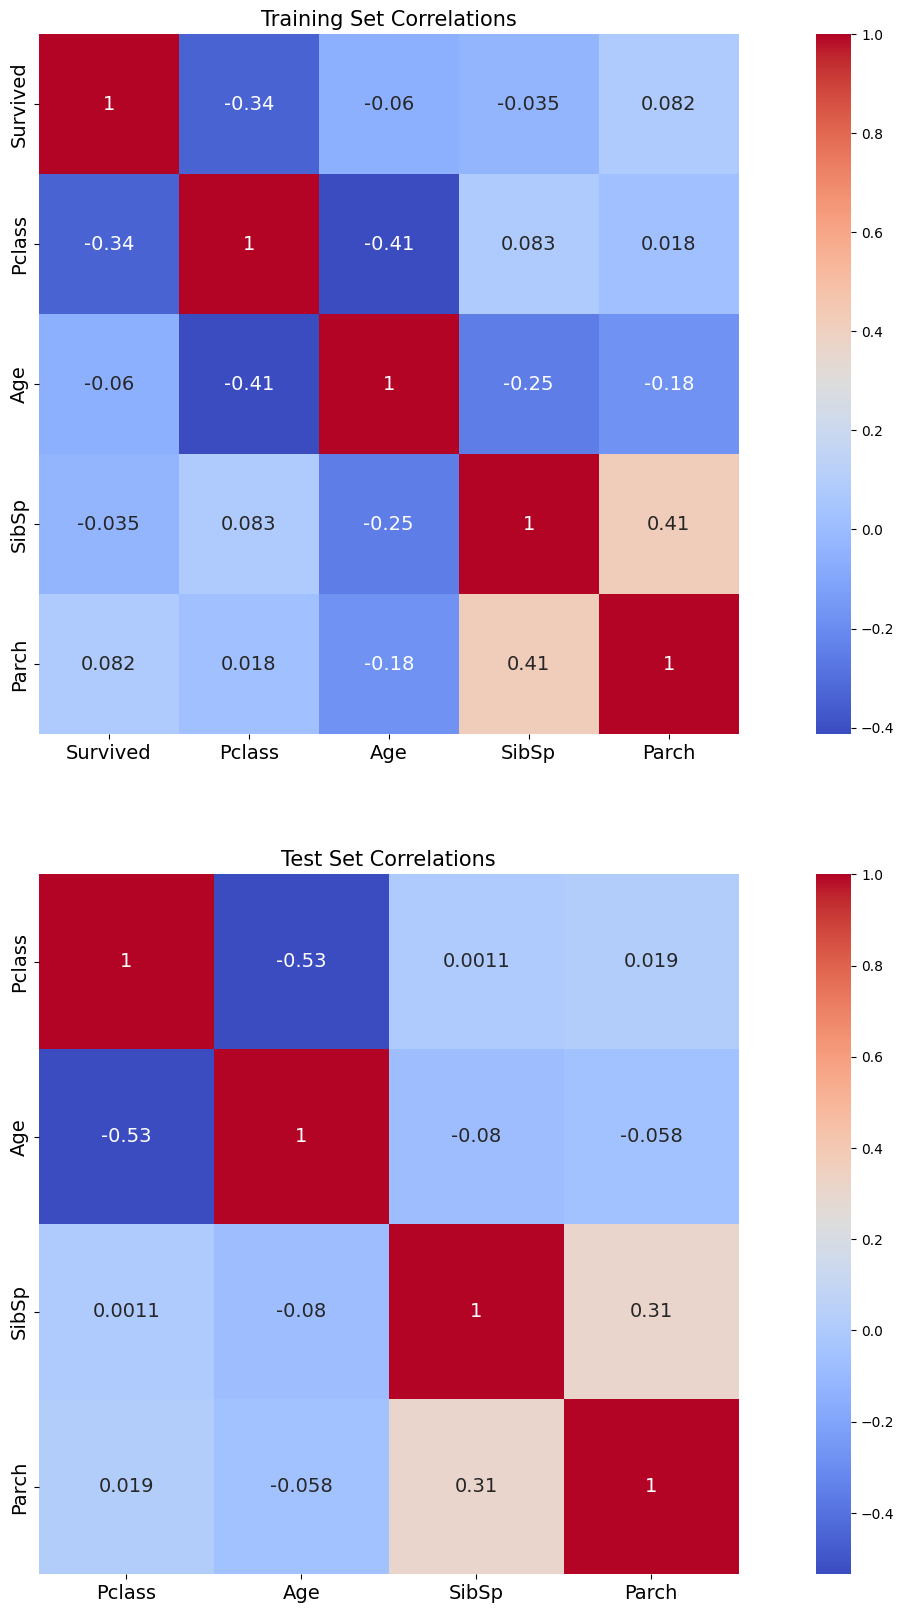

In [53]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### **2.2 Frequency Encoding**

`Family_Size` is calculated by summing `SibSp`, `Parch`, and **1**. `SibSp` represents the number of siblings and spouse, while `Parch` indicates the number of parents and children. These columns are combined to determine the total family size. Adding **1** accounts for the current passenger. Family size is a predictor of survival, with different family sizes having varying survival rates.

* Family Size of **1** is labeled as **Alone**
* Family Size of **2**, **3**, and **4** is labeled as **Small**
* Family Size of **5** and **6** is labeled as **Medium**
* Family Size of **7**, **8**, and **11** is labeled as **Large**


In [54]:
df_train['Family_Size'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family_Size'] = df_test['SibSp'] + df_test['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_train['Family_Size_Grouped'] = df_train['Family_Size'].map(family_map)
df_test['Family_Size_Grouped'] = df_test['Family_Size'].map(family_map)

The size of the group passengers traveled with is related to the survival rate. `Family Size Grouped` is a good indicator, but some passengers were traveling with maids, friends, etc., which is not captured in the `Family Size Grouped` feature. Therefore, I created an additional feature based on ticket frequency.


In [55]:
df_train['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')
df_test['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

*Grouping tiltes adding Is_Married feature*

In [56]:
df_train['Title'] = df_train['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_train['Is_Married'] = 0
df_train['Is_Married'].loc[df_train['Title'] == 'Mrs'] = 1
df_test['Title'] = df_test['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_test['Is_Married'] = 0
df_test['Is_Married'].loc[df_test['Title'] == 'Mrs'] = 1
df_train['Title'] = df_train['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_train['Title'] = df_train['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
df_test['Title'] = df_train['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_test['Title'] = df_test['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

/tmp/ipykernel_3618/3952878693.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_train['Is_Married'].loc[df_train['Title'] == 'Mrs'] = 1
/tmp/ipykernel_3618/3952878693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

*Extracting surnames from name feature*

In [57]:
def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train['Family'] = extract_surname(df_train['Name'])
df_test['Family'] = extract_surname(df_test['Name'])

### Survival Rate Calculation Process

1. **Family Survival Rate Calculation**:  
   - The `Family_Survival_Rate` feature is calculated based on families from the training set, since the test set does not have the `Survived` feature.
   - A list of family names that appear in both the training and test sets is created, referred to as `non_unique_families`.
   - For families with more than one member in this list, the survival rate is calculated and stored in the `Family_Survival_Rate` feature.

2. **Family Survival Rate Not Applicable (NA)**:  
   - An additional binary feature, `Family_Survival_Rate_NA`, is introduced for families that only exist in the test set.
   - This feature indicates that the family survival rate cannot be calculated for those passengers because the required data is not available.

3. **Ticket Survival Rate Calculation**:  
   - Similarly, the `Ticket_Survival_Rate` and `Ticket_Survival_Rate_NA` features are created using the same method as the family survival rate.
   - The `Ticket_Survival_Rate` is calculated for ticket groups based on training data, and the binary `Ticket_Survival_Rate_NA` flag is used when the survival rate cannot be calculated.

4. **Combining Survival Rates**:  
   - The `Family_Survival_Rate` and `Ticket_Survival_Rate` are averaged to form a combined feature called `Survival_Rate`.
   - Likewise, the `Family_Survival_Rate_NA` and `Ticket_Survival_Rate_NA` features are averaged to create a combined feature called `Survival_Rate_NA`.

This method ensures that missing survival data is accounted for, and the survival rates of both families and tickets are integrated for better predictive power.


In [58]:
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train[['Survived', 'Family','Family_Size']].groupby('Family').median()
df_ticket_survival_rate = df_train[['Survived', 'Ticket','Ticket_Frequency']].groupby('Ticket').median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

In [59]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA

In [60]:
for df in [df_train, df_test]:
    df['Survival_Rate'] = (df['Ticket_Survival_Rate'] + df['Family_Survival_Rate']) / 2
    df['Survival_Rate_NA'] = (df['Ticket_Survival_Rate_NA'] + df['Family_Survival_Rate_NA']) / 2    

In [61]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_Frequency,Title,Is_Married,Family,Family_Survival_Rate,Family_Survival_Rate_NA,Ticket_Survival_Rate,Ticket_Survival_Rate_NA,Survival_Rate,Survival_Rate_NA
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,"(-0.001, 7.25]",...,1,Mr,0,Braund,0.383838,0,0.383838,0,0.383838,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,"(53.1, 82.267]",...,2,Miss/Mrs/Ms,1,Cumings,1.000000,1,1.000000,1,1.000000,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,"(7.896, 8.662]",...,1,Miss/Mrs/Ms,0,Heikkinen,0.383838,0,0.383838,0,0.383838,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,"(31.275, 53.1]",...,2,Miss/Mrs/Ms,1,Futrelle,0.383838,0,0.383838,0,0.383838,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,"(7.896, 8.662]",...,1,Mr,0,Allen,0.383838,0,0.383838,0,0.383838,0.0


In [62]:
df_train.Title.value_counts()

Title
Mr                          517
Miss/Mrs/Ms                 313
Master                       40
Dr/Military/Noble/Clergy     21
Name: count, dtype: int64

In [63]:

non_numeric_features = ['Embarked', 'Sex', 'Deck','Family_Size_Grouped', 'AgeGrp', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])


In [64]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck', 'AgeGrp', 'Family_Size',
       'Family_Size_Grouped', 'Ticket_Frequency', 'Title', 'Is_Married',
       'Family', 'Family_Survival_Rate', 'Family_Survival_Rate_NA',
       'Ticket_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Survival_Rate',
       'Survival_Rate_NA'],
      dtype='object')

**Encoding Categorical Features**

In [65]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Family_Size_Grouped', 'AgeGrp',]


encoder = OneHotEncoder(sparse_output=False)  


encoded_train = encoder.fit_transform(df_train[cat_features])


encoded_test = encoder.transform(df_test[cat_features])


encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(cat_features))
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(cat_features))


encoded_train_df.index = df_train.index
encoded_test_df.index = df_test.index

df_train = df_train.drop(cat_features, axis=1)
df_test = df_test.drop(cat_features, axis=1)


df_train = pd.concat([df_train, encoded_train_df], axis=1)
df_test = pd.concat([df_test, encoded_test_df], axis=1)

In [66]:
df_train.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Family_Size', 'Ticket_Frequency', 'Title', 'Is_Married',
       'Family', 'Family_Survival_Rate', 'Family_Survival_Rate_NA',
       'Ticket_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Survival_Rate',
       'Survival_Rate_NA', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0',
       'Sex_1', 'Deck_0', 'Deck_1', 'Deck_2', 'Deck_3', 'Embarked_0',
       'Embarked_1', 'Embarked_2', 'Family_Size_Grouped_0',
       'Family_Size_Grouped_1', 'Family_Size_Grouped_2',
       'Family_Size_Grouped_3', 'AgeGrp_0', 'AgeGrp_1', 'AgeGrp_2', 'AgeGrp_3',
       'AgeGrp_4', 'AgeGrp_5'],
      dtype='object')

**Droping excessive columns**

In [67]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch', 'Family_Size','Age','Title','Family', 'Ticket_Survival_Rate', 'Family_Survival_Rate', 'Ticket_Survival_Rate_NA', 'Family_Survival_Rate_NA']
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)


In [68]:
df_train.columns

Index(['Survived', 'Fare', 'Ticket_Frequency', 'Is_Married', 'Survival_Rate',
       'Survival_Rate_NA', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_0',
       'Sex_1', 'Deck_0', 'Deck_1', 'Deck_2', 'Deck_3', 'Embarked_0',
       'Embarked_1', 'Embarked_2', 'Family_Size_Grouped_0',
       'Family_Size_Grouped_1', 'Family_Size_Grouped_2',
       'Family_Size_Grouped_3', 'AgeGrp_0', 'AgeGrp_1', 'AgeGrp_2', 'AgeGrp_3',
       'AgeGrp_4', 'AgeGrp_5'],
      dtype='object')

In [69]:
y = df_train['Survived']
X = df_train.drop(['Survived'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,random_state=69)

In [70]:
#leaderboard_model = RandomForestClassifier(criterion='gini',
#                                           n_estimators=1750,
#                                           max_depth=7,
#                                           min_samples_split=6,
#                                           min_samples_leaf=6,
#                                           max_features='sqrt',
#                                           oob_score=True,
#                                           random_state=69,
#                                           n_jobs=-1,
#                                           verbose=1)
leaderboard_model = RandomForestClassifier(criterion='gini',
                                             n_estimators=1750,
                                                max_depth=7,
                                                min_samples_split=5,
                                                min_samples_leaf=1,
                                                max_features='sqrt',
                                                oob_score=True,
                                                random_state=69,
                                                n_jobs=-1,
                                                verbose=1)

 

In [71]:
X_train.head()

,Fare,Ticket_Frequency,Is_Married,Survival_Rate,Survival_Rate_NA,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,...,Family_Size_Grouped_0,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,AgeGrp_0,AgeGrp_1,AgeGrp_2,AgeGrp_3,AgeGrp_4,AgeGrp_5
507,8,1,0,0.383838,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
201,10,11,0,0.000000,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
180,10,11,0,0.000000,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78,8,3,0,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
72,10,7,0,0.191919,0.5,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### **Submission file**

In [76]:
leaderboard_model.fit(X_train, y_train)
preds = leaderboard_model.predict(X_valid)
test_preds = leaderboard_model.predict(df_test)
accuracy = accuracy_score(y_valid, preds)
print(f"Accuracy: {accuracy}")

## Step 2: Create a DataFrame with PassengerId and the predictions
submission_df = pd.DataFrame({
    "PassengerId": range(892, 1310),
    "Survived": test_preds
})

# Step 3: Save the DataFrame to a CSV file
submission_df.to_csv("submission.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concur

Accuracy: 0.8435754189944135


### **Finding Best Model**

In [75]:
#param_grid = {
#    'criterion': ['gini', 'entropy'],
#    'n_estimators': [100,500,1000,1500,1750,2000],
#    'max_depth': [5,7,10,15],
#    'min_samples_split': [2,5,6,7,100],
#    'min_samples_leaf': [1, 2, 6, 10],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'oob_score': [True],
#    'random_state': [69],
#    'n_jobs': [-1],
#    'verbose': [1]
#}
param_grid = {
    'criterion': ['gini'],
    'n_estimators': [1750],
    'max_depth': [7],
    'min_samples_split': [5],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'oob_score': [True],
    'random_state': [69],
    'n_jobs': [-1],
    'verbose': [1]
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy',verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1750 out of 1750 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concur

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1750, 'n_jobs': -1, 'oob_score': True, 'random_state': 69, 'verbose': 1}
Best accuracy: 0.8455628878164088
